# Tuning G* Calculations

Things to try:

- Using percentiles instead of aggregated burden score
- Using raw values instead of aggregared burden score
- Using a different weight that is distance based rather than border based?

In [ ]:
# Load packages 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns         
import numpy as np
import os
import libpysal as lps 
from libpysal.weights import W 
from esda.getisord import G_Local
from docs.functions.map_burden import map_burden
import pprint
from functools import reduce
from scipy.stats import zscore
from scipy import stats

# Remove max columns
pd.set_option('display.max_columns', None)

In [ ]:
# Import data
base_dir = "/capstone/justice40"
# base_dir = "~/MEDS/justice40/data-exploration"

# 2.0 communities files (from current CEJST website)
comm_v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-communities.csv"))

# Version 2.0 shapefile data
v2_geo = gpd.read_file(os.path.join(base_dir, "data", "2.0-shapefile-codebook", "usa", "usa.shp"))

/tmp/ipykernel_673280/2332020531.py:9: DtypeWarning: Columns (18,29,73,75,88,134) have mixed types. Specify dtype option on import or set low_memory=False.
  comm_v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-communities.csv"))


In [ ]:
comm_small = comm_v2[['Census tract 2010 ID', 'County Name', 'State/Territory', 'Total threshold criteria exceeded', 'Total categories exceeded', 'Identified as disadvantaged', 'Total population']]

comm_small = comm_small.rename(columns={
    'Census tract 2010 ID': 'tract_id',
    'County Name':'county',
    'State/Territory':'state',
    'Total threshold criteria exceeded':'total_criteria', 
    'Total categories exceeded':'total_burdens', 
    'Identified as disadvantaged':'dac', 
    'Total population':'total_population'
})

# geometry, GEOID10
geo_join = v2_geo[['GEOID10', 'geometry']].rename(columns={'GEOID10':'tract_id'})
geo_join['tract_id'] =geo_join['tract_id'].astype('int64')

# Merge with geodf
complete = pd.merge(comm_small, geo_join, how='left', on='tract_id')

# Reassert GDF
complete =gpd.GeoDataFrame(complete)

# Drop geometry NAs
complete = complete[(complete.geometry.type == 'Polygon') |( complete.geometry.type == 'MultiPolygon')]

# Confirm our geometries are correct
complete.geom_type.unique()

## Trying Z-Score of a Z-Score

In [5]:
# First Z-score
burd_zscore = zscore(complete['total_burdens'])
ind_zscore = zscore(complete['total_criteria'])

complete['burd_zscore'] = burd_zscore
complete['ind_zscore'] = ind_zscore

In [6]:
complete.describe()

,tract_id,total_criteria,total_burdens,total_population,burd_zscore,ind_zscore
count,7.376700e+04,73767.000000,73767.000000,73740.000000,7.376700e+04,7.376700e+04
mean,2.843865e+10,1.611303,1.115892,4451.185693,-4.551242e-17,2.196155e-17
std,1.652436e+10,2.875070,1.798065,2331.857543,1.000007e+00,1.000007e+00
min,1.001020e+09,0.000000,0.000000,0.000000,-6.206113e-01,-5.604434e-01
25%,1.304591e+10,0.000000,0.000000,2914.750000,-6.206113e-01,-5.604434e-01
50%,2.804901e+10,0.000000,0.000000,4126.000000,-6.206113e-01,-5.604434e-01
75%,4.200347e+10,2.000000,2.000000,5557.000000,4.917031e-01,1.351965e-01
max,7.803096e+10,18.000000,8.000000,72041.000000,3.828646e+00,5.700316e+00


In [7]:
# Find the minimum value
complete['burd_zscore'].min()

np.float64(-0.6206113494154843)

In [8]:
# Add the absolute value of the minimum to the zscore to shift it
complete['burd_zscore'] = complete['burd_zscore'] + abs(complete['burd_zscore'].min())
complete['ind_zscore'] = complete['ind_zscore'] + abs(complete['ind_zscore'].min())

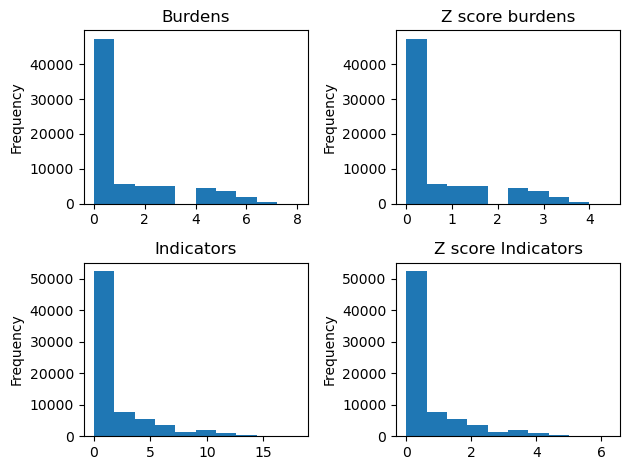

In [9]:
# Plot all 4 distributions
figure, axis = plt.subplots(2, 2)

# Regular burdens
complete['total_burdens'].plot(kind='hist', ax=axis[0,0])
axis[0,0].set_title('Burdens')

# Log burdens
complete['burd_zscore'].plot(kind='hist', ax=axis[0,1])
axis[0,1].set_title('Z score burdens')

# Regular ind
complete['total_criteria'].plot(kind='hist', ax=axis[1,0])
axis[1,0].set_title('Indicators')

# log ind
complete['ind_zscore'].plot(kind='hist', ax=axis[1,1])
axis[1,1].set_title('Z score Indicators')

plt.tight_layout()
plt.show()

In [38]:
# LISA

# Create weights using Queen method 
w = lps.weights.Queen(complete['geometry'])

# Run the Getis Ord test for burdens
gstar_burden = G_Local(complete['burd_zscore'], w, transform='R', permutations=9999) # Set transform=R because the queen weights are row-standardized weights.

# Run the Getis Ord test for criteria
gstar_crit = G_Local(complete['ind_zscore'], w, transform='R', permutations=9999)

/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 40 disconnected components.
 There are 19 islands with ids: 10022, 10463, 11538, 16613, 20502, 20518, 20549, 20554, 32755, 33437, 58373, 58520, 72746, 72747, 72748, 72813, 72814, 72833, 73155.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 10022, ' is an island (no neighbors)')
('WARNING: ', 10463, ' is an island (no neighbors)')
('WARNING: ', 11538, ' is an island (no neighbors)')
('WARNING: ', 16613, ' is an island (no neighbors)')
('WARNING: ', 20502, ' is an island (no neighbors)')
('WARNING: ', 20518, ' is an island (no neighbors)')
('WARNING: ', 20549, ' is an island (no neighbors)')
('WARNING: ', 20554, ' is an island (no neighbors)')
('WARNING: ', 32755, ' is an island (no neighbors)')
('WARNING: ', 33437, ' is an island (no neighbors)')
('WARNING: ', 58373, ' is an island (no neighbors)')
('WARNING: ', 58520, ' is an island (no neighbors)')
('WARNING: ', 72746, ' is an island (no neighbors)')
('WARNING: ', 72747, ' is an island (no neighbors)')
('WARNING: ', 72748, ' is an island (no neighbors)')
('WARNING: ', 72813, ' is an island (no neighbors)')
('WARNING: ', 72814, ' is an island (no neighbors)')
('WARNING: ', 72833, ' is an island (no neighbors)')
('WARNING: ', 73155, ' is an island (no neighb

/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


In [39]:
# Add burden stats to to a new df
# results = state_clean.drop('tract_id', axis=1).copy()
results = complete.copy()
results['gi_star_burd'] = gstar_burden.Zs 
results['p_norm_burd'] = gstar_burden.p_norm # p-value assuming normal distribution

# Add criteria stats
results['gi_star_ind'] = gstar_crit.Zs 
results['p_norm_ind'] = gstar_crit.p_norm # p-value assuming normal distribution

In [ ]:
# Filter to only continental 48 states
state_names = ["Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

# Took out alaska and hawaii for ease of mapping
results_cont = results[results['state'].isin(state_names)]

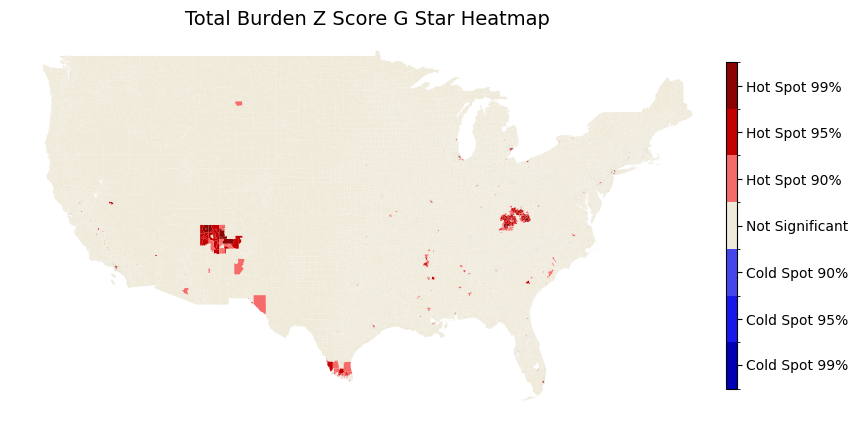

In [ ]:
# Define 5 distinct colors
colors = ["#0101b3", "#1818ed", "#4646ed", "#efeada", "#f76a6a", "#c50000", "#8c0303"]  

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)

# Define color boundaries
bounds = [-3, -2.58, -1.96, -1.645, 1.645, 1.96, 2.58, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Initialize figure
fig, ax = plt.subplots(figsize=(11,5))

# Remove axis for a cleaner map and set title
ax.axis('off')
ax.set_title(f"Total Burden Z Score G Star Heatmap",
            fontsize=14)

# Plot NY state and color by number of spills 
plot = results_cont.plot(ax=ax,
                column='gi_star_burd',
                cmap=cmap,
                norm=norm,
                legend=False)

# Get the colorbar from the plot
cbar = plot.get_figure().colorbar(plot.collections[0], ax=ax, 
orientation='vertical', pad=0, shrink=0.85, aspect=30)

# Modify the colorbar tick labels
cbar.set_ticks([-2.78, -2.27, -1.8, 0, 1.8, 2.27, 2.78])
cbar.set_ticklabels(['Cold Spot 99%', 'Cold Spot 95%', 'Cold Spot 90%', 'Not Significant', 'Hot Spot 90%', 'Hot Spot 95%', 'Hot Spot 99%']) 

plt.show()

## Trying log of burdens/indicators...

Okay... so log can't handle zeroes. Maybe I'll offset all the burdens by 1 and try again?

In [9]:
complete['total_burdens_1'] = complete['total_burdens'] + 1
complete['total_ind_1'] = complete['total_criteria'] + 1


In [10]:
# Nat log transformation
complete['log_burd'] = np.log(complete['total_burdens_1'])
complete['log_ind'] = np.log(complete['total_ind_1'])

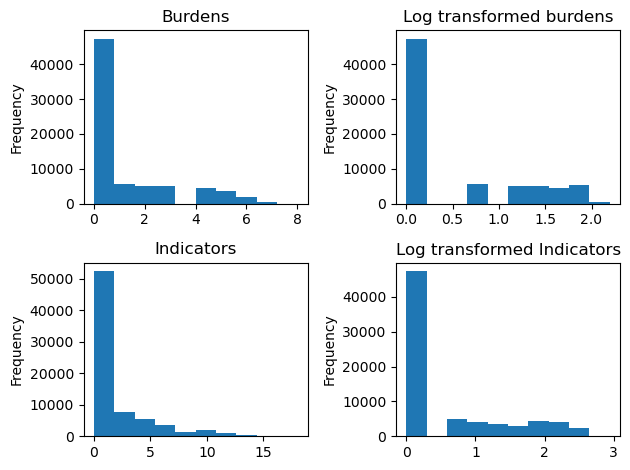

In [ ]:
# Plot all 4 distributions
figure, axis = plt.subplots(2, 2)

# Regular burdens
complete['total_burdens'].plot(kind='hist', ax=axis[0,0])
axis[0,0].set_title('Burdens')

# Log burdens
complete['log_burd'].plot(kind='hist', ax=axis[0,1])
axis[0,1].set_title('Log transformed burdens')

# Regular ind
complete['total_criteria'].plot(kind='hist', ax=axis[1,0])
axis[1,0].set_title('Indicators')

# log ind
complete['log_ind'].plot(kind='hist', ax=axis[1,1])
axis[1,1].set_title('Log transformed Indicators')

plt.tight_layout()
plt.show()


In [15]:
# LISA

# Create weights using Queen method 
w = lps.weights.Queen(complete['geometry'])

# Run the Getis Ord test for burdens
gstar_burden = G_Local(complete['log_burd'], w, transform='R', permutations=9999) # Set transform=R because the queen weights are row-standardized weights.

# Run the Getis Ord test for criteria
gstar_crit = G_Local(complete['log_ind'], w, transform='R', permutations=9999)

# Add burden stats to to a new df
# results = state_clean.drop('tract_id', axis=1).copy()
results = complete.copy()
results['gi_star_burd'] = gstar_burden.Zs 
results['p_norm_burd'] = gstar_burden.p_norm # p-value assuming normal distribution

# Add criteria stats
results['gi_star_ind'] = gstar_crit.Zs 
results['p_norm_ind'] = gstar_crit.p_norm # p-value assuming normal distribution

/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 40 disconnected components.
 There are 19 islands with ids: 10022, 10463, 11538, 16613, 20502, 20518, 20549, 20554, 32755, 33437, 58373, 58520, 72746, 72747, 72748, 72813, 72814, 72833, 73155.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 10022, ' is an island (no neighbors)')
('WARNING: ', 10463, ' is an island (no neighbors)')
('WARNING: ', 11538, ' is an island (no neighbors)')
('WARNING: ', 16613, ' is an island (no neighbors)')
('WARNING: ', 20502, ' is an island (no neighbors)')
('WARNING: ', 20518, ' is an island (no neighbors)')
('WARNING: ', 20549, ' is an island (no neighbors)')
('WARNING: ', 20554, ' is an island (no neighbors)')
('WARNING: ', 32755, ' is an island (no neighbors)')
('WARNING: ', 33437, ' is an island (no neighbors)')
('WARNING: ', 58373, ' is an island (no neighbors)')
('WARNING: ', 58520, ' is an island (no neighbors)')
('WARNING: ', 72746, ' is an island (no neighbors)')
('WARNING: ', 72747, ' is an island (no neighbors)')
('WARNING: ', 72748, ' is an island (no neighbors)')
('WARNING: ', 72813, ' is an island (no neighbors)')
('WARNING: ', 72814, ' is an island (no neighbors)')
('WARNING: ', 72833, ' is an island (no neighbors)')
('WARNING: ', 73155, ' is an island (no neighb

/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


In [16]:
# Filter to only continental 48 states
state_names = ["Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

# Took out alaska and hawaii for now

results_cont = results[results['state'].isin(state_names)]


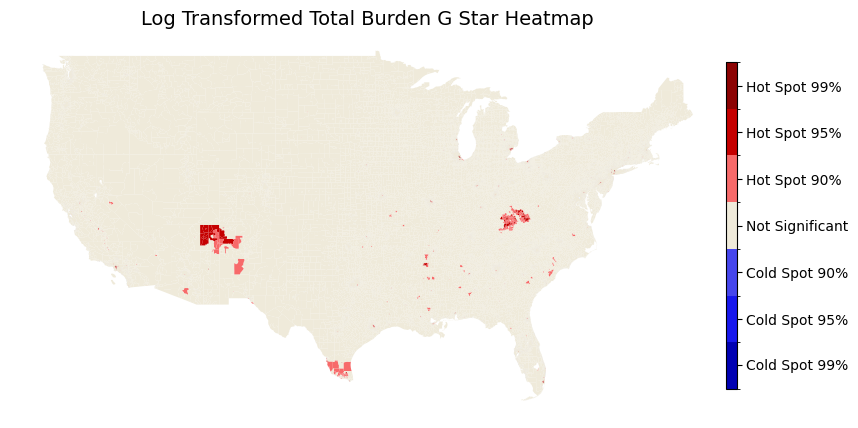

In [18]:
# Define 5 distinct colors
colors = ["#0101b3", "#1818ed", "#4646ed", "#efeada", "#f76a6a", "#c50000", "#8c0303"]  

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)

# Define color boundaries
bounds = [-3, -2.58, -1.96, -1.645, 1.645, 1.96, 2.58, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Initialize figure
fig, ax = plt.subplots(figsize=(11,5))

# Remove axis for a cleaner map and set title
ax.axis('off')
ax.set_title(f"Log Transformed Total Burden G Star Heatmap",
            fontsize=14)

# Plot NY state and color by number of spills 
plot = results_cont.plot(ax=ax,
                column='gi_star_burd',
                cmap=cmap,
                norm=norm,
                legend=False)

# Get the colorbar from the plot
cbar = plot.get_figure().colorbar(plot.collections[0], ax=ax, 
orientation='vertical', pad=0, shrink=0.85, aspect=30)

# Modify the colorbar tick labels
cbar.set_ticks([-2.78, -2.27, -1.8, 0, 1.8, 2.27, 2.78])
cbar.set_ticklabels(['Cold Spot 99%', 'Cold Spot 95%', 'Cold Spot 90%', 'Not Significant', 'Hot Spot 90%', 'Hot Spot 95%', 'Hot Spot 99%']) 

plt.show()

## Trying box-cox adjustment

In [11]:
# Apply Box-Cox transformation
xtb, _ = stats.boxcox(complete['total_burdens'] + 1)
xti, _ = stats.boxcox(complete['total_criteria'] + 1)

complete['bc_burdens'] = xtb
complete['bc_ind'] = xti


In [ ]:
# complete['total_burdens_1'] = complete['total_burdens'] + 1
# complete['total_ind_1'] = complete['total_criteria'] + 1

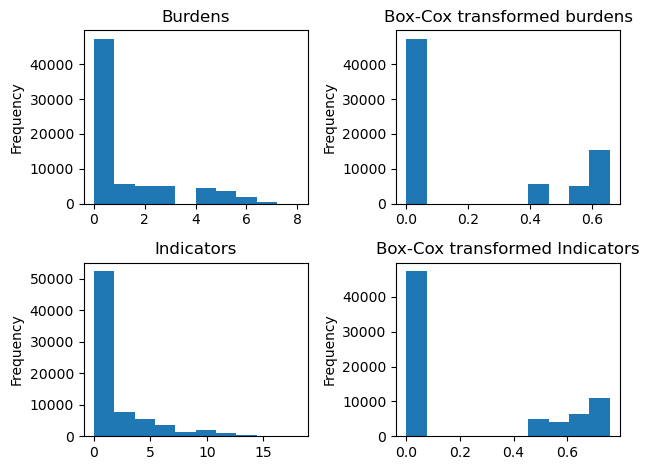

In [20]:
# Plot all 4 distributions
figure, axis = plt.subplots(2, 2)

# Regular burdens
complete['total_burdens'].plot(kind='hist', ax=axis[0,0])
axis[0,0].set_title('Burdens')

# Log burdens
complete['bc_burdens'].plot(kind='hist', ax=axis[0,1])
axis[0,1].set_title('Box-Cox transformed burdens')

# Regular ind
complete['total_criteria'].plot(kind='hist', ax=axis[1,0])
axis[1,0].set_title('Indicators')

# log ind
complete['bc_ind'].plot(kind='hist', ax=axis[1,1])
axis[1,1].set_title('Box-Cox transformed Indicators')

plt.tight_layout()
plt.show()


In [12]:
# LISA

# Create weights using Queen method 
w = lps.weights.Queen(complete['geometry'])

# Run the Getis Ord test for burdens
gstar_burden = G_Local(complete['bc_burdens'], w, transform='R', permutations=9999) # Set transform=R because the queen weights are row-standardized weights.

# Run the Getis Ord test for criteria
gstar_crit = G_Local(complete['bc_ind'], w, transform='R', permutations=9999)

# Add burden stats to to a new df
# results = state_clean.drop('tract_id', axis=1).copy()
results = complete.copy()
results['gi_star_bc_burd'] = gstar_burden.Zs 
results['p_norm_bc_burd'] = gstar_burden.p_norm # p-value assuming normal distribution

# Add criteria stats
results['gi_star_bc_ind'] = gstar_crit.Zs 
results['p_norm_bc_ind'] = gstar_crit.p_norm # p-value assuming normal distribution

/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 40 disconnected components.
 There are 19 islands with ids: 10022, 10463, 11538, 16613, 20502, 20518, 20549, 20554, 32755, 33437, 58373, 58520, 72746, 72747, 72748, 72813, 72814, 72833, 73155.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 10022, ' is an island (no neighbors)')
('WARNING: ', 10463, ' is an island (no neighbors)')
('WARNING: ', 11538, ' is an island (no neighbors)')
('WARNING: ', 16613, ' is an island (no neighbors)')
('WARNING: ', 20502, ' is an island (no neighbors)')
('WARNING: ', 20518, ' is an island (no neighbors)')
('WARNING: ', 20549, ' is an island (no neighbors)')
('WARNING: ', 20554, ' is an island (no neighbors)')
('WARNING: ', 32755, ' is an island (no neighbors)')
('WARNING: ', 33437, ' is an island (no neighbors)')
('WARNING: ', 58373, ' is an island (no neighbors)')
('WARNING: ', 58520, ' is an island (no neighbors)')
('WARNING: ', 72746, ' is an island (no neighbors)')
('WARNING: ', 72747, ' is an island (no neighbors)')
('WARNING: ', 72748, ' is an island (no neighbors)')
('WARNING: ', 72813, ' is an island (no neighbors)')
('WARNING: ', 72814, ' is an island (no neighbors)')
('WARNING: ', 72833, ' is an island (no neighbors)')
('WARNING: ', 73155, ' is an island (no neighb

/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


In [14]:
# Filter to only continental 48 states
state_names = ["Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

# Took out alaska and hawaii for now

results_cont = results[results['state'].isin(state_names)]


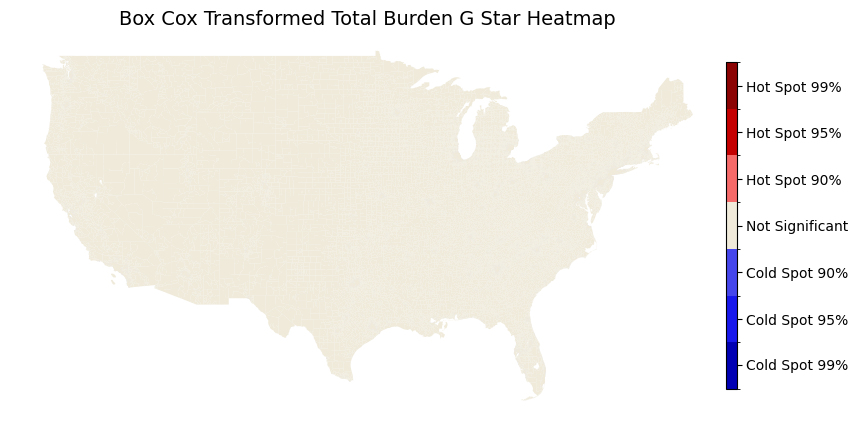

In [15]:
# Define 5 distinct colors
colors = ["#0101b3", "#1818ed", "#4646ed", "#efeada", "#f76a6a", "#c50000", "#8c0303"]  

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)

# Define color boundaries
bounds = [-3, -2.58, -1.96, -1.645, 1.645, 1.96, 2.58, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Initialize figure
fig, ax = plt.subplots(figsize=(11,5))

# Remove axis for a cleaner map and set title
ax.axis('off')
ax.set_title(f"Box Cox Transformed Total Burden G Star Heatmap",
            fontsize=14)

# Plot NY state and color by number of spills 
plot = results_cont.plot(ax=ax,
                column='gi_star_bc_burd',
                cmap=cmap,
                norm=norm,
                legend=False)

# Get the colorbar from the plot
cbar = plot.get_figure().colorbar(plot.collections[0], ax=ax, 
orientation='vertical', pad=0, shrink=0.85, aspect=30)

# Modify the colorbar tick labels
cbar.set_ticks([-2.78, -2.27, -1.8, 0, 1.8, 2.27, 2.78])
cbar.set_ticklabels(['Cold Spot 99%', 'Cold Spot 95%', 'Cold Spot 90%', 'Not Significant', 'Hot Spot 90%', 'Hot Spot 95%', 'Hot Spot 99%']) 

plt.show()

Clearly that worked well...

## Trying permutation based gi star

ALKSDJHFLASKDJ this is the same things as the permutations inside the `G_Local` function. I was trying to do this separately, because I didn't know how the function worked well enough to recognize these were the same things. This didn't end up working anyways.

In [ ]:
# # Define the variable of interest 
# y = complete['total_burdens'].values

# # LISA

# # Create weights using Queen method 
# w = lps.weights.Queen(complete['geometry'])

# # Compute observed Local G* statistic
# # g_star = G_Local(y, w)
# g_star = G_Local(y, w, transform='R') 

# # Number of permutations
# n_permutations = 999

# # Store permuted G* values
# perm_gi_star = np.zeros((n_permutations, len(y)))

# # Perform permutation test
# for i in range(n_permutations):
#     np.random.shuffle(y)  # Shuffle values
#     perm_g_star = G_Local(y, w, transform='R').Zs  # Compute G* for shuffled data
#     perm_gi_star[i, :] = perm_g_star

# # Compute pseudo p-values
# observed_g_star = g_star.Zs
# pseudo_p_values = (np.abs(perm_gi_star) >= np.abs(observed_g_star)).sum(axis=0) / n_permutations

# # Add results to the GeoDataFrame
# results = complete.copy()
# results["g_star"] = observed_g_star
# results["p_value"] = pseudo_p_values

